<a href="https://colab.research.google.com/github/AbhishekSinghKushwah7/Plant-Disease-Identification-via-Deep-Learning/blob/main/GoogleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experiment 2**

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/new_drive')

Drive already mounted at /content/new_drive; to attempt to forcibly remount, call drive.mount("/content/new_drive", force_remount=True).


In [3]:
source_dir = "/content/new_drive/MyDrive/Colab Notebooks/thermal images UL"
output_dir = "/content/new_drive/MyDrive/Colab Notebooks/thermal images UL"

classes = ['Blast', 'BLB', 'healthy', 'hispa', 'leaf folder', 'leaf spot']


In [4]:
# Step 1: Data Preparation
def prepare_data(source_dir, output_dir, classes, test_size=0.2, val_size=0.2):
    splits = ['train', 'validation', 'test']

    # Create directories for splits
    for split in splits:
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

    # List all images and split data
    for cls in classes:
        class_dir = os.path.join(source_dir, cls)
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('jpg', 'png'))]

        # Split into train, validation, and test sets
        train_val_images, test_images = train_test_split(images, test_size=test_size, random_state=42)
        train_images, val_images = train_test_split(train_val_images, test_size=val_size, random_state=42)

        # Copy images to respective directories
        for img_path in train_images:
            shutil.copy(img_path, os.path.join(output_dir, 'train', cls))
        for img_path in val_images:
            shutil.copy(img_path, os.path.join(output_dir, 'validation', cls))
        for img_path in test_images:
            shutil.copy(img_path, os.path.join(output_dir, 'test', cls))

    print("Dataset preparation complete.")

In [5]:
# Prepare dataset
prepare_data(source_dir, output_dir, classes)

Dataset preparation complete.


In [32]:
# Step 2: Create Data Generators
def create_data_generators(output_dir, img_size=(224, 224), batch_size=32):
    datagen_train = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    datagen_val_test = ImageDataGenerator(rescale=1./255)

    train_generator = datagen_train.flow_from_directory(
        os.path.join(output_dir, 'train'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = datagen_val_test.flow_from_directory(
        os.path.join(output_dir, 'validation'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = datagen_val_test.flow_from_directory(
        os.path.join(output_dir, 'test'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, val_generator, test_generator

In [7]:
# Create data generators
train_gen, val_gen, test_gen = create_data_generators(output_dir)

Found 586 images belonging to 6 classes.
Found 317 images belonging to 6 classes.
Found 222 images belonging to 6 classes.


In [33]:
# Step 3: Build GoogleNet Model
def build_googlenet_model(input_shape=(224, 224, 3), num_classes=6):
    """Build a GoogleNet (InceptionV1) model for classification."""
    inputs = layers.Input(shape=input_shape)

    # Stem of GoogleNet
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Inception Modules
    def inception_module(x, filters):
        f1, f3r, f3, f5r, f5, proj = filters

        path1 = layers.Conv2D(f1, (1, 1), padding='same', activation='relu')(x)

        path2 = layers.Conv2D(f3r, (1, 1), padding='same', activation='relu')(x)
        path2 = layers.Conv2D(f3, (3, 3), padding='same', activation='relu')(path2)

        path3 = layers.Conv2D(f5r, (1, 1), padding='same', activation='relu')(x)
        path3 = layers.Conv2D(f5, (5, 5), padding='same', activation='relu')(path3)

        path4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
        path4 = layers.Conv2D(proj, (1, 1), padding='same', activation='relu')(path4)

        return layers.concatenate([path1, path2, path3, path4], axis=-1)

    x = inception_module(x, [64, 96, 128, 16, 32, 32])
    x = inception_module(x, [128, 128, 192, 32, 96, 64])
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [192, 96, 208, 16, 48, 64])
    x = inception_module(x, [160, 112, 224, 24, 64, 64])
    x = inception_module(x, [128, 128, 256, 24, 64, 64])
    x = inception_module(x, [112, 144, 288, 32, 64, 64])
    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x = inception_module(x, [384, 192, 384, 48, 128, 128])

    # Classification Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [34]:
# Build the model
model = build_googlenet_model()

In [35]:
# Step 4: Train the Model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 266s 13s/step - accuracy: 0.2972 - loss: 1.7525 - val_accuracy: 0.3407 - val_loss: 1.6427 - learning_rate: 1.0000e-04
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 230s 12s/step - accuracy: 0.3379 - loss: 1.6604 - val_accuracy: 0.3407 - val_loss: 1.6354 - learning_rate: 1.0000e-04
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 218s 12s/step - accuracy: 0.3170 - loss: 1.6668 - val_accuracy: 0.3407 - val_loss: 1.6151 - learning_rate: 1.0000e-04
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 218s 11s/step - accuracy: 0.3394 - loss: 1.6147 - val_accuracy: 0.3407 - val_loss: 1.5838 - learning_rate: 1.0000e-04
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 234s 12s/step - accuracy: 0.3352 - loss: 1.6036 - val_accuracy: 0.3375 - val_loss: 1.5478 - learning_rate: 1.0000e-04
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 234s 12s/step - accuracy: 0.3516 - loss: 1.5539 - val_accuracy: 0.3438 - val_loss: 1.4856 - learning_rate: 1.0000e-04
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 215s 11s/step - accuracy: 

In [36]:
# Step 5: Evaluate the Model
eval_results = model.evaluate(test_gen)
print(f"Test Accuracy: {eval_results[1] * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.4272 - loss: 1.3922
Test Accuracy: 40.99%


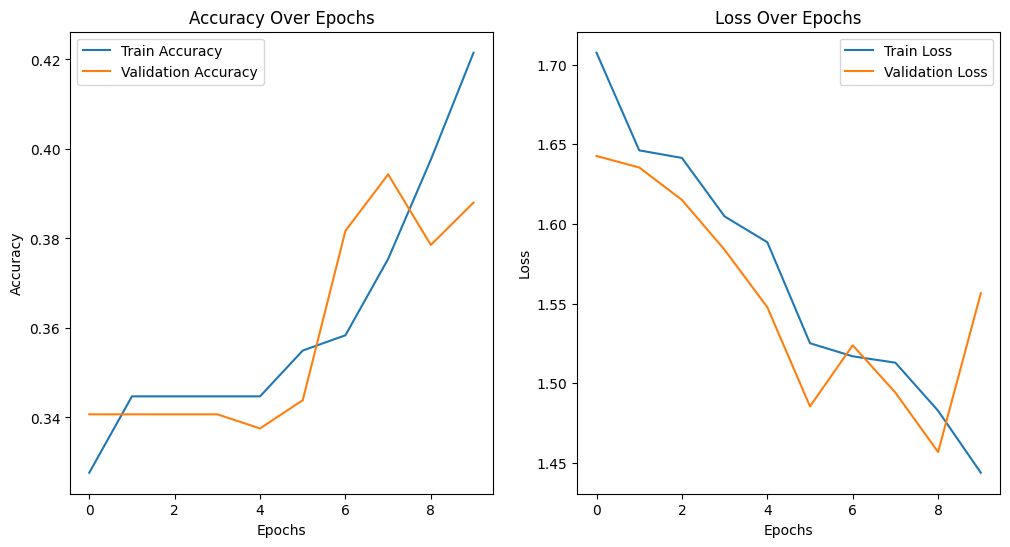

In [37]:
# Step 6: Plot Training and Validation Accuracy and Loss
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

In [ ]:
# Save the model
model.save("SegNet.h5")
print("Model saved.")

Model saved.
